https://learn.astropy.org/tutorials/color-excess.html

https://chatgpt.com/share/694e5167-5230-8007-b714-f17d3dd4930d

In [1]:
import pathlib
import numpy as np
import astropy.units as u
from astropy.table import Table
from dust_extinction.parameter_averages import CCM89, F99
from synphot import units, config
from synphot import SourceSpectrum, SpectralElement, Observation, ReddeningLaw
from synphot.models import BlackBodyNorm1D
from astroquery.simbad import Simbad
from astroquery.mast import Observations
import astropy.visualization
import matplotlib.pyplot as plt

%matplotlib inline

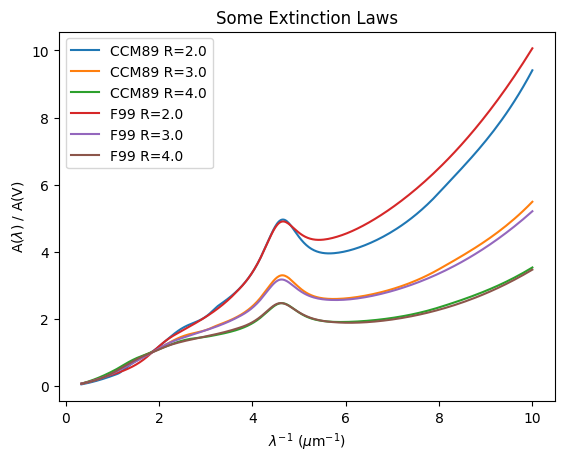

In [2]:
# Create wavelengths array.
wav = np.arange(0.1, 3.0, 0.001) * u.micron

for model in [CCM89, F99]:
    for R in (2.0, 3.0, 4.0):
        # Initialize the extinction model
        ext = model(Rv=R)
        plt.plot(1 / wav, ext(wav), label=model.name + " R=" + str(R))

plt.xlabel(r"$\lambda^{-1}$ ($\mu$m$^{-1}$)")
plt.ylabel(r"A($\lambda$) / A(V)")
plt.legend(loc="best")
plt.title("Some Extinction Laws")
plt.show()

In [3]:
download_dir = pathlib.Path("~/.astropy/cache/astroquery/Mast").expanduser()
download_dir.mkdir(exist_ok=True, parents=True)

obsTable = Observations.query_object("HD 147933", radius="1 arcsec")
obsTable_spec = obsTable[obsTable["dataproduct_type"] == "spectrum"]
obsTable_spec

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
str7,str5,str7,str13,str6,str17,str16,str21,str87,str53,float64,float64,str10,str22,int64,float64,float64,float64,float64,float64,str117,float64,str6,str6,int64,str23309,str137,str137,str6,bool,float64,str9,float64
science,JWST,APT,MIRI/IFU,JWST,F770W,INFRARED,HD147933,--,jw07715021001_xx101_00001_miri,246.39632750000004,-23.447175000000016,spectrum,"Decleir, Marjorie",-1,nan,nan,16.65,6600.0,8800.0,Unique insights into the chemical composition of interstellar silicate dust grains in the Milky Way,nan,7715,GO,1,POLYGON 246.39628332931 -23.44647682166 246.39724452752 -23.44660740232 246.39707945891 -23.44762998653 246.39611825342 -23.44749937708,--,--,PUBLIC,False,nan,250358393,0.0
science,JWST,APT,MIRI/IFU,JWST,F770W,INFRARED,HD147933,--,jw07715021001_xx102_00002_miri,246.39632750000004,-23.447175000000016,spectrum,"Decleir, Marjorie",-1,nan,nan,16.65,6600.0,8800.0,Unique insights into the chemical composition of interstellar silicate dust grains in the Milky Way,nan,7715,GO,2,POLYGON 246.39564102259 -23.44666562072 246.39660222154 -23.44679620531 246.39643714773 -23.44781878885 246.39547594149 -23.44768817546,--,--,PUBLIC,False,nan,250358394,0.0
science,JWST,APT,MIRI/IFU,JWST,F770W,INFRARED,HD147933,--,jw07715021001_xx103_00003_miri,246.39632750000004,-23.447175000000016,spectrum,"Decleir, Marjorie",-1,nan,nan,16.65,6600.0,8800.0,Unique insights into the chemical composition of interstellar silicate dust grains in the Milky Way,nan,7715,GO,3,POLYGON 246.39618623396 -23.44653838938 246.39714743253 -23.44666897063 246.39698236309 -23.44769155474 246.39602115724 -23.4475609447,--,--,PUBLIC,False,nan,250358395,0.0
science,JWST,APT,MIRI/IFU,JWST,F770W,INFRARED,HD147933,--,jw07715021001_xx104_00004_miri,246.39632750000004,-23.447175000000016,spectrum,"Decleir, Marjorie",-1,nan,nan,16.65,6600.0,8800.0,Unique insights into the chemical composition of interstellar silicate dust grains in the Milky Way,nan,7715,GO,4,POLYGON 246.39554415903 -23.44672814693 246.39650535835 -23.44685873212 246.3963402837 -23.44788131555 246.3953790771 -23.44775070157,--,--,PUBLIC,False,nan,250358396,0.0
science,JWST,APT,MIRI/IFU,JWST,F1000W,INFRARED,HD147933,--,jw07715021001_xx105_00001_miri,246.39632750000004,-23.447175000000016,spectrum,"Decleir, Marjorie",-1,nan,nan,19.425,9000.0,11000.0,Unique insights into the chemical composition of interstellar silicate dust grains in the Milky Way,nan,7715,GO,5,POLYGON 246.39628332931 -23.44647682166 246.39724452752 -23.44660740232 246.39707945891 -23.44762998653 246.39611825342 -23.44749937708,--,--,PUBLIC,False,nan,250358397,0.0
science,JWST,APT,MIRI/IFU,JWST,F1000W,INFRARED,HD147933,--,jw07715021001_xx106_00002_miri,246.39632750000004,-23.447175000000016,spectrum,"Decleir, Marjorie",-1,nan,nan,19.425,9000.0,11000.0,Unique insights into the chemical composition of interstellar silicate dust grains in the Milky Way,nan,7715,GO,6,POLYGON 246.39564102259 -23.44666562072 246.39660222154 -23.44679620531 246.39643714773 -23.44781878885 246.39547594149 -23.44768817546,--,--,PUBLIC,False,nan,250358398,0.0
science,JWST,APT,MIRI/IFU,JWST,F1000W,INFRARED,HD147933,--,jw07715021001_xx107_00003_miri,246.39632750000004,-23.447175000000016,spectrum,"Decleir, Marjorie",-1,nan,nan,19.425,9000.0,11000.0,Unique insights into the chemical composition of interstellar silicate dust grains in the Milky Way,nan,7715,GO,7,POLYGON 246.39618623396 -23.44653838938 246.39714743253 -23.44666897063 246.39698236309 -23.44769155474 246.39602115724 -23.4475609447,--,--,PUBLIC,False,nan,250358399,0.0
science,JWST,APT,MIRI/IFU,JWST,F1000W,INFRARED,HD147933,--,jw07715021001_xx108_00004_miri,246.396327500

In [4]:
# retrieve a specific 'obs_id' corresponding to the IUE spectrum
obsTable_spec.add_index("obs_id")
obsids = obsTable_spec.loc["lwr05639"]["obsid"]

dataProductsByID = Observations.get_product_list(obsids)
manifest = Observations.download_products(
    dataProductsByID, download_dir=str(download_dir)
)

In [5]:
t_lwr = Table.read(download_dir / "mastDownload/IUE/lwr05639/lwr05639mxlo_vo.fits")
print(t_lwr)

         WAVE                    FLUX            ... QUALITY
       Angstrom         erg / (Angstrom s cm2)   ...        
--------------------- -------------------------- ... -------
1851.4327 .. 3348.901 2.08651e-10 .. 7.39839e-11 ... 0 .. 16


In [6]:
wav_UV = t_lwr["WAVE"][0,].quantity
UVflux = t_lwr["FLUX"][0,].quantity

In [7]:
custom_query = Simbad()
custom_query.add_votable_fields("U", "B", "V")
phot_table = custom_query.query_object("HD 147933")
Umag = phot_table["U"]
Bmag = phot_table["B"]
Vmag = phot_table["V"]

In [8]:
wav_U = 0.3660 * u.micron
zeroflux_U_nu = 1.81e-23 * u.Watt / (u.m * u.m * u.Hz)
wav_B = 0.4400 * u.micron
zeroflux_B_nu = 4.26e-23 * u.Watt / (u.m * u.m * u.Hz)
wav_V = 0.5530 * u.micron
zeroflux_V_nu = 3.64e-23 * u.Watt / (u.m * u.m * u.Hz)

In [9]:
zeroflux_U = zeroflux_U_nu.to(
    u.erg / u.AA / u.cm / u.cm / u.s, equivalencies=u.spectral_density(wav_U)
)
zeroflux_B = zeroflux_B_nu.to(
    u.erg / u.AA / u.cm / u.cm / u.s, equivalencies=u.spectral_density(wav_B)
)
zeroflux_V = zeroflux_V_nu.to(
    u.erg / u.AA / u.cm / u.cm / u.s, equivalencies=u.spectral_density(wav_V)
)

In [10]:
Uflux = zeroflux_U * 10.0 ** (-0.4 * Umag)
Bflux = zeroflux_B * 10.0 ** (-0.4 * Bmag)
Vflux = zeroflux_V * 10.0 ** (-0.4 * Vmag)

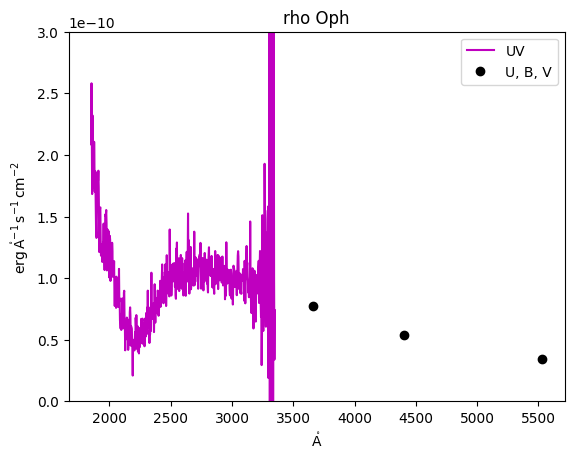

In [11]:
astropy.visualization.quantity_support()

plt.plot(wav_UV, UVflux, "m", label="UV")
plt.plot(wav_V, Vflux, "ko", label="U, B, V")
plt.plot(wav_B, Bflux, "ko")
plt.plot(wav_U, Uflux, "ko")
plt.legend(loc="best")
plt.ylim(0, 3e-10)
plt.title("rho Oph")
plt.show()

In [12]:
Rv = 5.0  # Usually around 3, but about 5 for this star.
Ebv = 0.5
ext = F99(Rv=Rv)

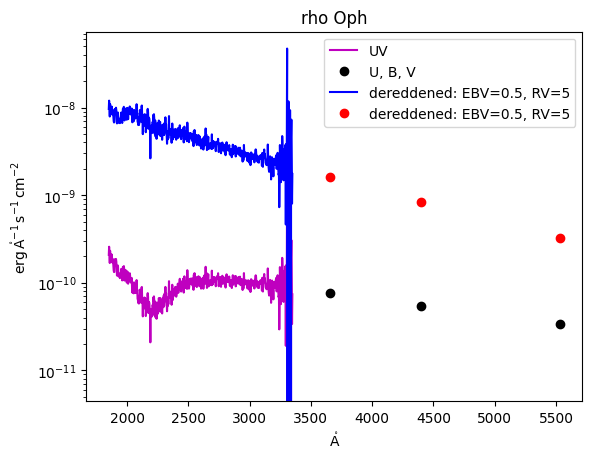

In [13]:
plt.semilogy(wav_UV, UVflux, "m", label="UV")
plt.semilogy(wav_V, Vflux, "ko", label="U, B, V")
plt.semilogy(wav_B, Bflux, "ko")
plt.semilogy(wav_U, Uflux, "ko")

plt.semilogy(
    wav_UV,
    UVflux / ext.extinguish(wav_UV, Ebv=Ebv),
    "b",
    label="dereddened: EBV=0.5, RV=5",
)
plt.semilogy(
    wav_V,
    Vflux / ext.extinguish(wav_V, Ebv=Ebv),
    "ro",
    label="dereddened: EBV=0.5, RV=5",
)
plt.semilogy(wav_B, Bflux / ext.extinguish(wav_B, Ebv=Ebv), "ro")
plt.semilogy(wav_U, Uflux / ext.extinguish(wav_U, Ebv=Ebv), "ro")

plt.legend(loc="best")
plt.title("rho Oph")
plt.show()

In [14]:
# Optional, for when the STScI ftp server is not answering:
root_url = "http://ssb.stsci.edu/trds/"
config.conf.vega_file = root_url + "calspec/alpha_lyr_stis_010.fits"
config.conf.johnson_u_file = root_url + "comp/nonhst/johnson_u_004_syn.fits"
config.conf.johnson_b_file = root_url + "comp/nonhst/johnson_b_004_syn.fits"
config.conf.johnson_v_file = root_url + "comp/nonhst/johnson_v_004_syn.fits"
config.conf.johnson_r_file = root_url + "comp/nonhst/johnson_r_003_syn.fits"
config.conf.johnson_i_file = root_url + "comp/nonhst/johnson_i_003_syn.fits"
config.conf.bessel_j_file = root_url + "comp/nonhst/bessell_j_003_syn.fits"
config.conf.bessel_h_file = root_url + "comp/nonhst/bessell_h_004_syn.fits"
config.conf.bessel_k_file = root_url + "comp/nonhst/bessell_k_003_syn.fits"

u_band = SpectralElement.from_filter("johnson_u")
b_band = SpectralElement.from_filter("johnson_b")
v_band = SpectralElement.from_filter("johnson_v")
r_band = SpectralElement.from_filter("johnson_r")
i_band = SpectralElement.from_filter("johnson_i")
j_band = SpectralElement.from_filter("bessel_j")
h_band = SpectralElement.from_filter("bessel_h")
k_band = SpectralElement.from_filter("bessel_k")

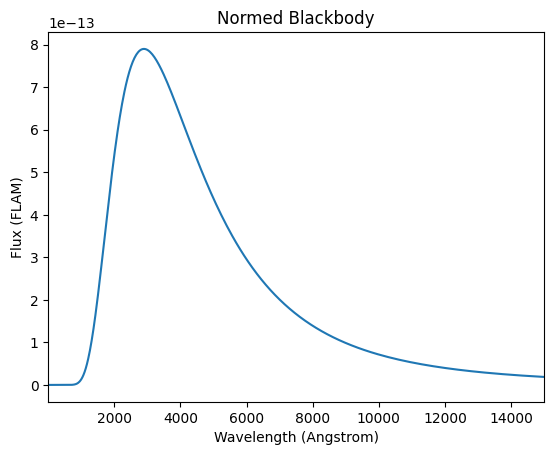

In [15]:
# First, create a blackbody at some temperature.
sp = SourceSpectrum(BlackBodyNorm1D, temperature=10000)
# sp.plot(left=1, right=15000, flux_unit='flam', title='Blackbody')

# Get the Vega spectrum as the zero point flux.
vega = SourceSpectrum.from_vega()
# vega.plot(left=1, right=15000)

# Normalize the blackbody to some chosen magnitude, say V = 10.
vmag = 10.0
v_band = SpectralElement.from_filter("johnson_v")
sp_norm = sp.normalize(vmag * units.VEGAMAG, v_band, vegaspec=vega)
sp_norm.plot(left=1, right=15000, flux_unit="flam", title="Normed Blackbody")

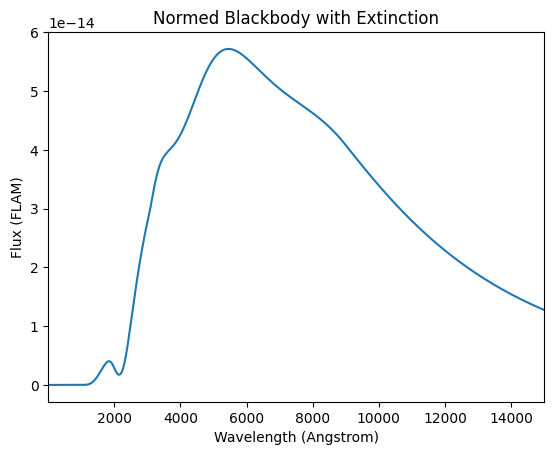

In [16]:
# Initialize the extinction model and choose the extinction, here Av = 2.
ext = CCM89(Rv=3.1)
Av = 2.0

# Create a wavelength array.
wav = np.arange(0.1, 3, 0.001) * u.micron

# Make the extinction model in synphot using a lookup table.
ex = ReddeningLaw(ext).extinction_curve(Av / ext.Rv, wavelengths=wav)
sp_ext = sp_norm * ex
sp_ext.plot(
    left=1, right=15000, flux_unit="flam", title="Normed Blackbody with Extinction"
)

In [17]:
# "Observe" the star through the filter and integrate to get photometric mag.
sp_obs = Observation(sp_ext, v_band)
sp_obs_before = Observation(sp_norm, v_band)
# sp_obs.plot(left=1, right=15000, flux_unit='flam',
#             title='Normed Blackbody with Extinction through V Filter')

In [18]:
sp_stim_before = sp_obs_before.effstim(flux_unit="vegamag", vegaspec=vega)
sp_stim = sp_obs.effstim(flux_unit="vegamag", vegaspec=vega)
print("before dust, V =", np.round(sp_stim_before, 1))
print("after dust, V =", np.round(sp_stim, 1))

# Calculate extinction and compare to our chosen value.
Av_calc = sp_stim - sp_stim_before
print("$A_V$ = ", np.round(Av_calc, 1))

before dust, V = 10.0 mag(VEGA)
after dust, V = 12.0 mag(VEGA)
$A_V$ =  2.0 mag


3601.5 Angstrom , 1.12 mag
4368.9 Angstrom , 0.63 mag
5463.8 Angstrom , 0.0 mag
6810.6 Angstrom , -0.48 mag
8619.6 Angstrom , -0.97 mag
12266.5 Angstrom , -1.43 mag
16351.9 Angstrom , -1.65 mag
21956.7 Angstrom , -1.79 mag


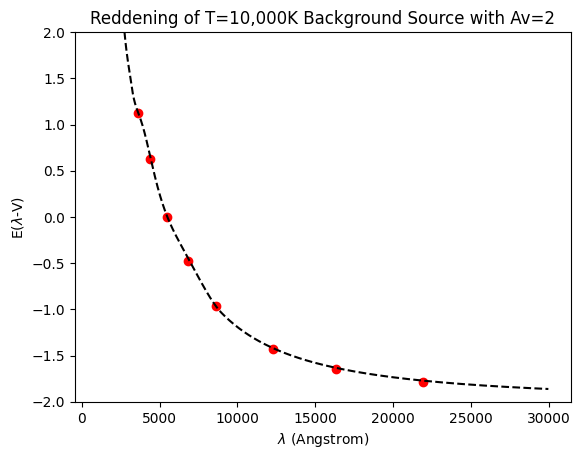

In [19]:
bands = [u_band, b_band, v_band, r_band, i_band, j_band, h_band, k_band]

for band in bands:
    # Calculate photometry with dust:
    sp_obs = Observation(sp_ext, band, force="extrap")
    obs_effstim = sp_obs.effstim(flux_unit="vegamag", vegaspec=vega)
    # Calculate photometry without dust:
    sp_obs_i = Observation(sp_norm, band, force="extrap")
    obs_i_effstim = sp_obs_i.effstim(flux_unit="vegamag", vegaspec=vega)

    # Extinction = mag with dust - mag without dust
    # Color excess = extinction at lambda - extinction at V
    color_excess = obs_effstim - obs_i_effstim - Av_calc
    plt.plot(sp_obs_i.effective_wavelength(), color_excess, "or")
    print(np.round(sp_obs_i.effective_wavelength(), 1), ",", np.round(color_excess, 2))

# Plot the model extinction curve for comparison
plt.plot(wav, Av * ext(wav) - Av, "--k")
plt.ylim([-2, 2])
plt.xlabel(r"$\lambda$ (Angstrom)")
plt.ylabel(r"E($\lambda$-V)")
plt.title("Reddening of T=10,000K Background Source with Av=2")
plt.show()